In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection, decomposition
sns.set(rc={'figure.figsize':(10,10)})

### CART Algorithm

Classification and Regression trees were cooked up in the famous CART paper penned by Leo Breiman, Jerome Friedman and Charles J. Stone in 1984. There's [a nice 5 minute video](https://www.youtube.com/watch?v=ZIET5K1uob8) of Breiman describing his conception of CART on YouTube.

In [24]:
def node(i, s, p, c, l, r):
    return {'internal': i,
            'split': s,
            'predictor': p,
            'prediction':c,
            'left':l,
            'right':r}

def build_subtree(df, y, impurity_fn, predict_fn, min_samples_leaf=2):
    N,M = df.shape
    lowest_impurity = None
    best_l_mask, best_r_mask = None, None
    best_predictor, best_split = None, None
    for m in range(0, M):
        for n in range(0, N):
            l_mask = df.iloc[:,m] <= df.iloc[n, m]
            r_mask = l_mask == False
            if l_mask.sum() < min_samples_leaf or r_mask.sum() < min_samples_leaf:
                continue
            impurity = impurity_fn(y[l_mask], y[r_mask])
            if lowest_impurity == None or (impurity < lowest_impurity):
                lowest_impurity = impurity
                best_l_mask, best_r_mask = l_mask, r_mask
                best_predictor, best_split = m, df.iloc[n, m]
    if lowest_impurity == None:
        return node(False, best_split, best_predictor, predict_fn(y), None, None)
    left = build_subtree(df[best_l_mask], y[best_l_mask], impurity_fn, predict_fn, min_samples_leaf)
    right = build_subtree(df[best_r_mask], y[best_r_mask], impurity_fn, predict_fn, min_samples_leaf)
    return node(True, best_split, best_predictor, predict_fn(y), left, right)
    
def predict(tree, df):
    queue = [(tree, df)]
    result = pd.DataFrame()
    while len(queue) > 0:
        tree, df = queue.pop()
        if tree['internal'] == False:
            ps = pd.Series([tree['prediction']]).repeat(df.shape[0])
            ps.index = df.index
            ps = ps.rename('y')
            res = pd.concat([df, ps], axis=1)
            result = result.append(res)
        else:
            l_mask = df.iloc[:,tree['predictor']] <= tree['split']
            r_mask = l_mask == False
            queue.append((tree['left'], df[l_mask]))
            queue.append((tree['right'], df[r_mask]))
    return result

### Visualisation

In [27]:
def plot_boundries(tree, xmin, xmax, ymin, ymax):
    if tree['internal'] == False:
        x = xmin + (0.5 * (xmax - xmin))
        y = ymin + (0.5 * (ymax - ymin))
        if type(tree['prediction']) == bool:
            plt.text(x, y, tree['prediction'])
        else:
            plt.text(x, y, round(tree['prediction'], 3))
        return
    s = tree['split']
    if tree['predictor'] == 0:
        plt.plot([s, s], [ymin, ymax], c='black')
        plot_boundries(tree['left'], xmin, s, ymin, ymax)
        plot_boundries(tree['right'], s, xmax, ymin, ymax)
    else:
        plt.plot([xmin, xmax],[s, s], c='black')
        plot_boundries(tree['left'], xmin, xmax, ymin, s)
        plot_boundries(tree['right'], xmin, xmax, s, ymax)
        
def plot_scatter_with_boundries(df, y, tree):
    df.columns = ['x1', 'x2']
    y = y.rename('y')
    scatter_df = pd.concat([df, y], axis=1)
    ax = sns.scatterplot(x='x1', y='x2', hue='y', data=scatter_df, palette='rocket')
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    plot_boundries(tree, xmin, xmax, ymin, ymax)

### Classification Tree

In [28]:
def cross_entropy_k2_impurity(l, r):
    n = l.size + r.size
    e1 = entropy_k2(l)
    e2 = entropy_k2(r)
    return ((l.size/n) * e1) + ((r.size/n) * e2)

def entropy_k2(x):
    p = x.sum() / x.size
    q = 1 - p
    return 0 if p == 0 or p == 1 else (-p * np.log2(p)) + (- q * np.log2(q))

**Example 1**: Generated Dataset

In [29]:
n = 200
k = 4
class_1 = np.random.normal([0, 1], 1, (n//k, 2))
class_2 = np.random.normal([0, 8], 1,(n//k, 2))
df = pd.concat([pd.DataFrame(class_1), pd.DataFrame(class_2)], axis=0, ignore_index=True)
y = df.sum(axis=1) > df.sum(axis=1).mean()

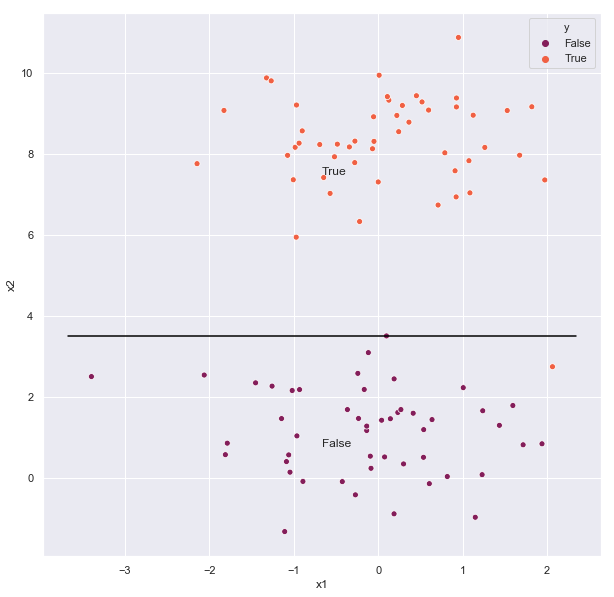

In [31]:
tree = build_subtree(df, y, cross_entropy_k2_impurity, lambda x: bool(x.mode()[0]), min_samples_leaf=50)
plot_scatter_with_boundries(df, y, tree)

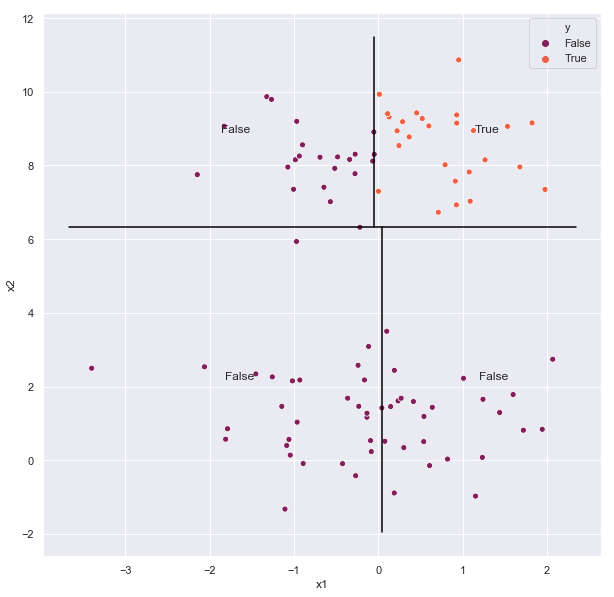

In [32]:
y = ((df.iloc[:,0] > df.iloc[:,0].mean()) &  (df.iloc[:,1] > df.iloc[:,1].mean()))
tree = build_subtree(df, y, cross_entropy_k2_impurity, lambda x: bool(x.mode()[0]), min_samples_leaf=20)
plot_scatter_with_boundries(df, y, tree)

### Regression Trees

In [33]:
def sq_error_impurity(l, r):
    return l.var() + r.var()

**Example 1**: Generated Dataset

In [38]:
n = 200
k = 4
class_1 = np.random.normal([0, 1], 1, (n//k, 2))
class_2 = np.random.normal([0, 10], 1,(n//k, 2))
df = pd.concat([pd.DataFrame(class_1), pd.DataFrame(class_2)], axis=0, ignore_index=True)
y = df.sum(axis=1)

`min_samples_leaf = 20`

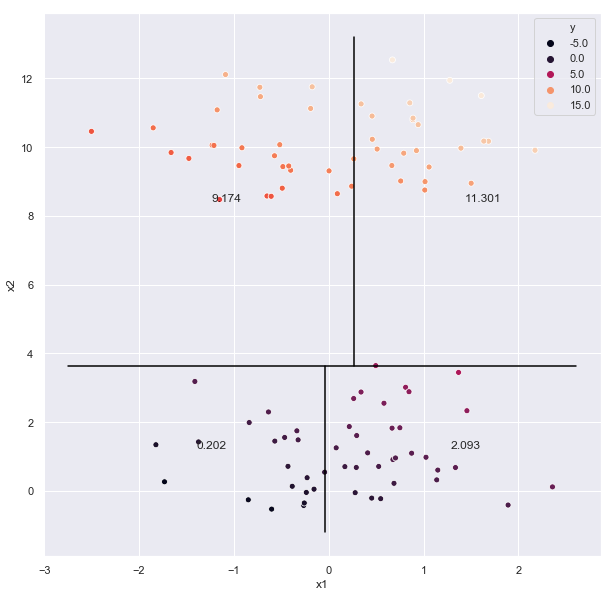

In [39]:
tree = build_subtree(df, y, sq_error_impurity, lambda x: x.mean(), min_samples_leaf=20)
plot_scatter_with_boundries(df, y, tree)

`min_samples_leaf = 10`

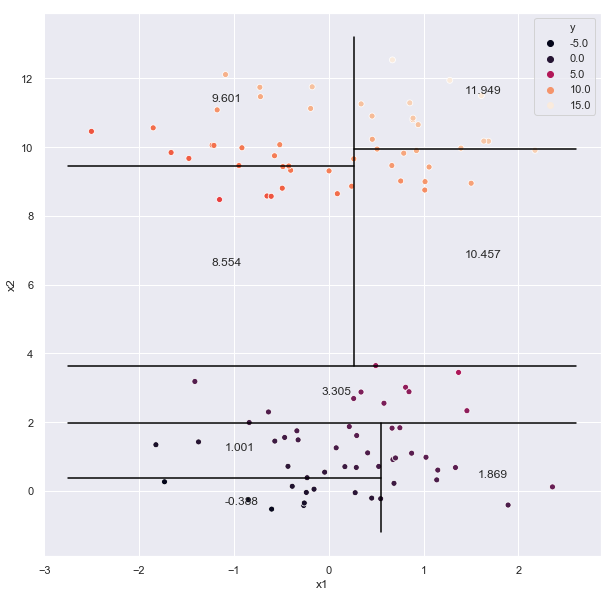

In [40]:
tree = build_subtree(df, y, sq_error_impurity, lambda x: x.mean(), min_samples_leaf=10)
plot_scatter_with_boundries(df, y, tree)

`min_samples_leaf = 2`

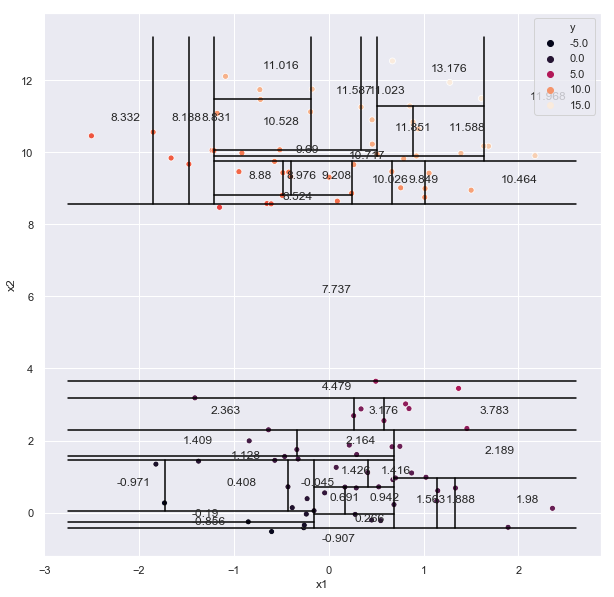

In [41]:
tree = build_subtree(df, y, sq_error_impurity, lambda x: x.mean(), min_samples_leaf=2)
plot_scatter_with_boundries(df, y, tree)

**Example 2**: Boston Housing

In [43]:
boston_data = datasets.load_boston()
df_boston = pd.DataFrame(boston_data.data,columns=boston_data.feature_names)
df_boston = (df_boston - df_boston.mean()) / df_boston.std()
pca = decomposition.PCA(n_components=2)
boston_X = pd.DataFrame(pca.fit_transform(df_boston), columns=['pc1', 'pc2'])
boston_y = pd.Series(boston_data.target).rename('target')
df_boston = pd.concat([boston_X, boston_y], axis=1)
train, test = model_selection.train_test_split(df_boston, test_size=0.5)
train_X = train.drop('target', axis=1)
train_y = train['target']
test_X = test.drop('target', axis=1)
test_y = test['target']

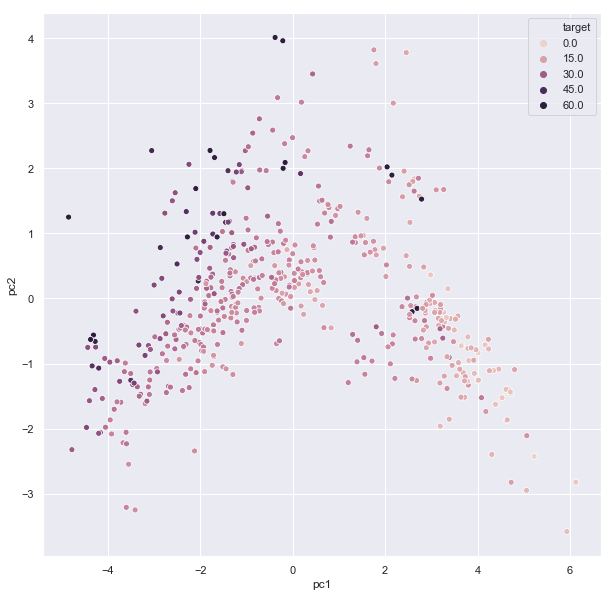

In [44]:
scatter_df = pd.concat([boston_X, boston_y], axis=1)
sns.scatterplot(x='pc1', y='pc2', hue='target', data=scatter_df)

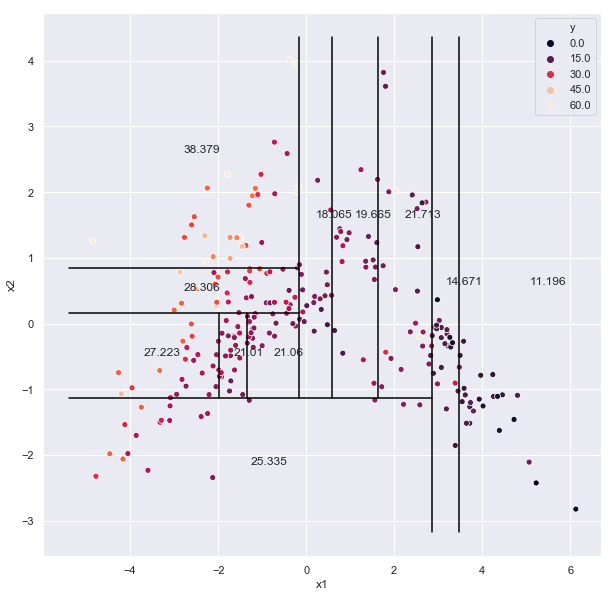

In [45]:
tree = build_subtree(train_X, train_y, sq_error_impurity, lambda x: x.mean(), min_samples_leaf=20)
plot_scatter_with_boundries(train_X, train_y, tree)

In [46]:
# evaluate training error
preds = predict(tree, train_X)['y']
print('training error: {}'.format(np.sqrt(((train_y - preds) ** 2).sum() / train_y.shape[0])))

# evaluate test error
preds = predict(tree, test_X)['y']
print('test error: {}'.format(np.sqrt(((test_y - preds) ** 2).sum() / test_y.shape[0])))

training error: 5.922714642656245
test error: 7.45800695601511


### Bagging

Leo Brieman [first described bagging in 1996](https://link.springer.com/content/pdf/10.1023%2FA%3A1018054314350.pdf).

In [47]:
def bagged_trees(X, y, min_samples_leaf, b):
    n = X.shape[0]
    trees = []
    for _ in range(0, b):
        b_sample = np.random.randint(0, n, n)
        xx = X.iloc[b_sample, :]
        yy = y.iloc[b_sample]
        tree = build_subtree(xx, yy, sq_error_impurity, lambda x: x.mean(), min_samples_leaf=min_samples_leaf)
        trees.append(tree)
    return trees

**Example**: Boston Housing

In [50]:
min_samples_leaf = 20
b = 10
trees = bagged_trees(train_X, train_y, min_samples_leaf, b)

In [51]:
# evaluate training error
indi_preds = [predict(t, train_X)['y'] for t in trees]
preds = pd.concat(indi_preds, axis=1).mean(axis=1)
print('training error: {}'.format(np.sqrt(((train_y - preds) ** 2).sum() / train_y.shape[0])))

# evaluate test error
indi_preds = [predict(t, test_X)['y'] for t in trees]
preds = pd.concat(indi_preds, axis=1).mean(axis=1)
print('test error: {}'.format(np.sqrt(((test_y - preds) ** 2).sum() / test_y.shape[0])))

training error: 5.697871545163693
test error: 6.596075351420024


### Random Forests

Tin Kam Ho is credited with [the first description](https://web.archive.org/web/20160417030218/http://ect.bell-labs.com/who/tkh/publications/papers/odt.pdf) of random decision forests in 1995. Leo Brieman is credited with [the introduction of random forests proper]((https://link.springer.com/article/10.1023%2FA%3A1010933404324)) in 2001.

In [57]:
def build_random_forest_subtree(df, y, m, impurity_fn, predict_fn, min_samples_leaf=2):
    N,M = df.shape
    lowest_impurity = None
    best_l_mask, best_r_mask = None, None
    best_predictor, best_split = None, None
    
    # Putting the 'random' in random forests 
    # --------------------------------------
    ps = np.random.choice(np.arange(0, df.shape[1]), m, replace=False)
    for m in ps:
    # --------------------------------------
    
        for n in range(0, N):
            l_mask = df.iloc[:,m] <= df.iloc[n, m]
            r_mask = l_mask == False
            if l_mask.sum() < min_samples_leaf or r_mask.sum() < min_samples_leaf:
                continue
            impurity = impurity_fn(y[l_mask], y[r_mask])
            if lowest_impurity == None or (impurity < lowest_impurity):
                lowest_impurity = impurity
                best_l_mask, best_r_mask = l_mask, r_mask
                best_predictor, best_split = m, df.iloc[n, m]
    if lowest_impurity == None:
        return node(False, best_split, best_predictor, predict_fn(y), None, None)
    
    # Putting the 'random' in random forests 
    # --------------------------------------
    left = build_random_forest_subtree(df[best_l_mask], y[best_l_mask], m, impurity_fn, predict_fn, min_samples_leaf)
    right = build_random_forest_subtree(df[best_r_mask], y[best_r_mask], m, impurity_fn, predict_fn, min_samples_leaf)
    # --------------------------------------
    
    return node(True, best_split, best_predictor, predict_fn(y), left, right)

In [54]:
def random_forest_trees(X, y, m, min_samples_leaf, b):
    n = X.shape[0]
    trees = []
    for _ in range(0, b):
        b_sample = np.random.randint(0, n, n)
        xx = X.iloc[b_sample, :]
        yy = y.iloc[b_sample]
        tree = build_random_forest_subtree(xx, yy, m, sq_error_impurity, lambda x: x.mean(), min_samples_leaf=min_samples_leaf)
        trees.append(tree)
    return trees

**Example**: Boston Housing

In [58]:
min_samples_leaf = 2
b = 10
m = int(np.floor(np.sqrt(train_X.shape[1])))
trees = random_forest_trees(train_X, train_y, m, min_samples_leaf, b)

In [59]:
# evaluate training error
indi_preds = [predict(t, train_X)['y'] for t in trees]
preds = pd.concat(indi_preds, axis=1).mean(axis=1)
print('training error: {}'.format(np.sqrt(((train_y - preds) ** 2).sum() / train_y.shape[0])))

# evaluate test error
indi_preds = [predict(t, test_X)['y'] for t in trees]
preds = pd.concat(indi_preds, axis=1).mean(axis=1)
print('test error: {}'.format(np.sqrt(((test_y - preds) ** 2).sum() / test_y.shape[0])))

training error: 8.40706750612003
test error: 8.098611207928053


### Boosting

Yoav Freund and Robert E.Schapire first described [AdaBoost](http://www.site.uottawa.ca/~stan/csi5387/boost-tut-ppr.pdf) in 1995. Leo Breiman [had some thoughts](https://statistics.berkeley.edu/sites/default/files/tech-reports/486.pdf) towards the end of the 90's and Jerome Friedman was [working on gradient boosting](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf) by 1999/2000.

In [61]:
b = 10
n = train_X.shape[0]
d = (n / 2) -1
lbda = 0.01
y_hat = np.repeat(train_y.mean(), n)
resid = train_y - y_hat
trees = []

while b > 0 :
    tree = build_subtree(train_X, resid, sq_error_impurity, lambda x: x.mean(), d)
    trees.append(tree)
    preds = predict(tree, train_X)['y']
    update = preds * lbda
    resid = resid - update
    b -= 1

# evaluate test error
indi_preds = [predict(t, test_X)['y'] for t in trees]
preds = pd.concat(indi_preds, axis=1).mean(axis=1)
preds += train_y.mean()
print('test error: {}'.format(np.sqrt(((test_y - preds) ** 2).sum() / test_y.shape[0])))

test error: 7.55456676491796
